In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import r2_score, mean_squared_error
import theano.tensor as tt
import pandas as pd
from pandas.plotting import scatter_matrix
from tqdm import tqdm
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16

In [23]:
tqdm.monitor_interval = 0

In [3]:
class PyMCModel:
    def __init__(self, model, model_name='None'):
        self.model = model
        self.model.name = model_name
        
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

    
def hs_regression(X, y_obs, ylabel='y', tau_0=None, regularized=False, **kwargs):
    """See Piironen & Vehtari, 2017 (DOI: 10.1214/17-EJS1337SI)"""
    if tau_0 is None:
        M = X.shape[1]
        m0 = M/2
        N = X.shape[0]
        tau_0 = m0 / ((M - m0) * np.sqrt(N))
    if regularized:
        slab_scale = kwargs.pop('slab_scale', 3)
        slab_scale_sq = slab_scale ** 2
        slab_df = kwargs.pop('slab_df', 8)
        half_slab_df = slab_df / 2
        with pm.Model() as mhsr:
            tau = pm.HalfCauchy('tau', tau_0)
            c_sq = pm.InverseGamma('c_sq', alpha=half_slab_df, beta=half_slab_df * slab_scale_sq)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            lamb_m_bar = tt.sqrt(c_sq) * lamb_m / (tt.sqrt(c_sq + tt.pow(tau, 2)*tt.pow(lamb_m, 2)))
            w = pm.Normal('w', mu=0, sd=tau*lamb_m_bar, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhsr
    else:
        with pm.Model() as mhs:
            tau = pm.HalfCauchy('tau', tau_0)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            w = pm.Normal('w', mu=0, sd = tau*lamb_m, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhs

    
def lasso_regression(X, y_obs, add_bias=True, ylabel='y'):
    if add_bias:
        X = np.c_[np.ones((X.shape[0],)), X]
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=10)
        sig = pm.HalfCauchy('sigma', beta=10)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=X.shape[1])
        mu_ = pm.Deterministic('mu', tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso

def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    if add_bias:
        X = np.c_[np.ones((X.shape[0], )), X]
    with pm.Model() as mhlass:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        wh = pm.Normal


def biome_hier_regression(X, y_obs, add_bias=True, ylabel='y'):
    if add_bias:
        X = np.c_[np.ones((X.shape[0],)), X]
    with pm.Model() as mbhlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        wh = 

def Plot_Model_Fits(trace, model, title=None, ax=None):
    mu_log10chl = trace.get_values('mu')
    mu_log10chl_mean = np.median(mu_log10chl, axis=0)

    mu_hpd = pm.hpd(mu_log10chl)

    ppc_y = pm.sample_ppc(trace, model=model)['y']
    mn = ppc_y.mean(axis=0)
    hpd = pm.hpd(ppc_y)
    rmse = np.sqrt(mean_squared_error(y, mu_log10chl_mean))
    r2 = r2_score(y, mu_log10chl_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 18), nrows=2)
    ax[0].set_title('Model Fit')
    ax[0].set_xlabel('modeled')
    ax[0].set_ylabel('observed')
    ax[0].scatter(mu_log10chl_mean, y, color='k', alpha=0.5,
                 label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
    ax[0].plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
    ax[0].axis('equal')
    ax[0].legend(loc='best')
    ix = np.argsort(y.ravel())
    xi = np.arange(y.size)
    ax[1].set_title('Posterior Predictive Checks')
    ax[1].set_xlabel('obs #')
    ax[1].set_ylabel('$log_{10}(chl)$')
    ax[1].plot(y.ravel()[ix], ls='', marker='.', color='k', label='Obs')
    ax[1].plot(mn[ix], ls='', color='r', marker='o', markersize=10,
               alpha=0.7, label='PPC mean')
    ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                       alpha=0.3, label='PPC 95% Cred. Int.');
    ax[1].legend(loc='best');
    f = pl.gcf()
    f.suptitle(title, y=1.01);
    f.tight_layout()
    return ax

In [4]:
ds = pd.read_pickle('./pickleJar/df_4_AllFeatures_stdized.pkl')
dps = pd.read_pickle('./pickleJar/df_4_AllFeaturesPoly_stdized.pkl')
dpcapoly_s = pd.read_pickle('./pickleJar/df_4_AllFeaturesPcaPoly_stdized.pkl')

In [5]:
ds.head()

,sin_doy_s,cos_doy_s,sin_minofday_s,cos_minofday_s,x_s,y_s,z_s,log10_etopo2_s,oisst_s,solz_s,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s,log10_chl
0,-1.385151,0.393676,3.331764,-1.286440,1.628934,2.938612,0.602308,0.537394,-0.077755,1.241402,0.351266,-0.762884,-0.737736,0.330311,-1.037654,0.594934,-1.040959
1,1.028077,1.044360,-0.540883,-0.220649,0.231942,0.728266,-4.090760,1.253630,-2.578876,1.411297,0.870624,-0.610153,-0.802267,-0.638707,-1.264113,0.514432,-0.928118
2,0.455535,1.517444,0.752610,-1.480395,0.364565,0.783759,-4.078996,1.084519,-2.689025,1.051119,1.014308,0.496331,0.088608,1.015205,-0.268243,1.265004,-0.211832
3,-1.403424,0.035733,2.178265,-1.665971,2.070054,1.010965,-0.094027,1.326652,0.671259,-0.165333,1.548007,0.031205,0.608765,0.133692,-0.416693,-1.694552,-0.801343
4,0.928487,-0.906496,3.804903,-0.911560,1.930407,2.735461,-3.024444,0.078166,-0.424358,1.438481,-1.277924,-0.002770,-0.329040,0.137882,-0.648940,0.028175,0.420995


In [18]:
X_s = ds.loc[:, ds.columns!='log10_chl'].values
Xp_s = dps.loc[:, dps.columns!='log10_chl'].values
Xpcap_s = dpcapoly_s.loc[:, dpcapoly_s.columns!='log10_chl'].values
y = ds.log10_chl

In [6]:
m_lasso = lasso_regression(X_s, y, ylabel='y')

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '28224' (I am process '8623')


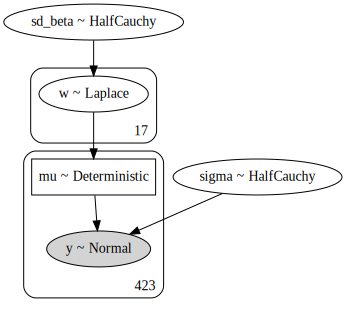

In [42]:
pm.model_to_graphviz(model=m_lasso)

In [7]:
with m_lasso:
    t_lasso = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1936.47draws/s]


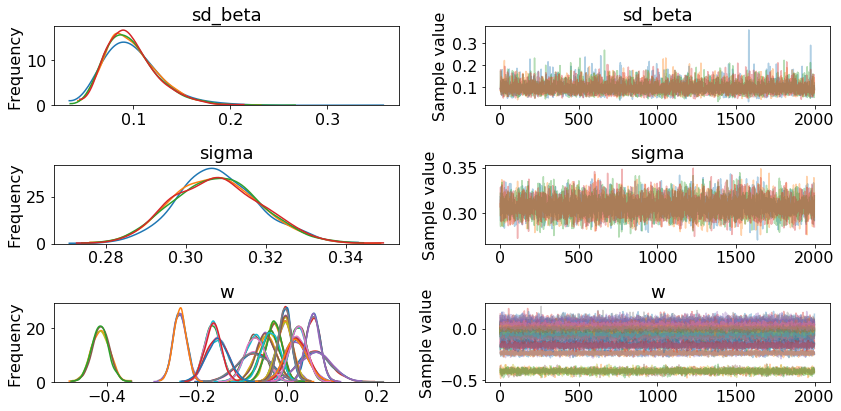

In [8]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(t_lasso, varnames=vars_);

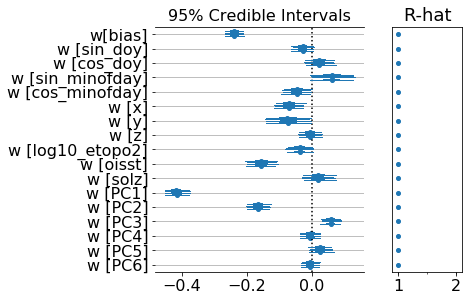

In [9]:
lbls = ds.columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
pm.forestplot(t_lasso, varnames='w', ylabels=lbls_list);
f = pl.gcf()
a = f.get_axes()[1]
a.grid(axis='y')

100%|██████████| 2000/2000 [00:01<00:00, 1896.18it/s]


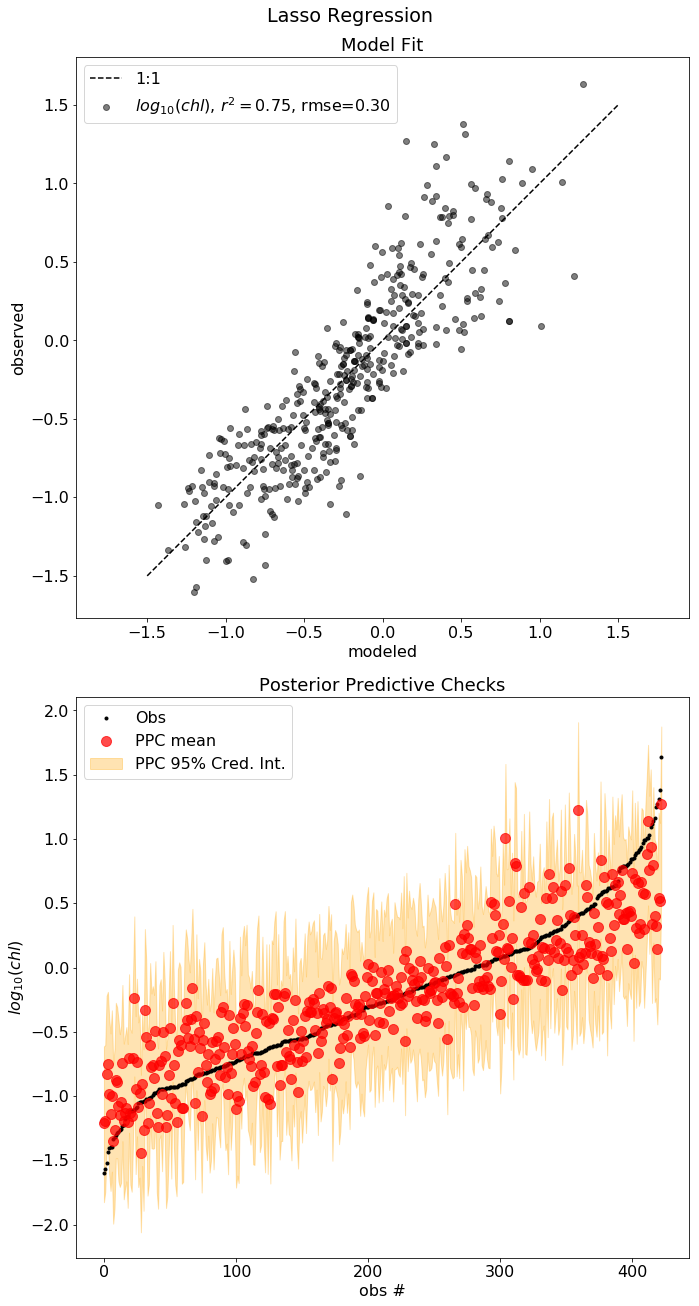

In [11]:
title = 'Lasso Regression'
ax0ls = Plot_Model_Fits(t_lasso, m_lasso, title=title)

In [66]:
d_lasso = pm.summary(t_lasso, varnames=vars_)
lbls = ds.columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
d_lasso.index = ['sd_beta', 'sigma'] + lbls_list
d_lasso[(((d_lasso['hpd_2.5']<0)&(d_lasso['hpd_97.5']<0))|
          ((d_lasso['hpd_2.5']>0) & (d_lasso['hpd_97.5']>0)))]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sd_beta,0.098464,0.027420,0.000260,0.052347,0.152324,8676.101253,1.000154
sigma,0.307750,0.010706,0.000094,0.286798,0.328305,10954.069403,1.000055
w[bias],-0.237927,0.014785,0.000161,-0.268099,-0.210206,10782.601314,0.999807
w [cos_minofday],-0.046817,0.022221,0.000241,-0.089566,-0.001907,8146.564525,0.999930
w [x],-0.069783,0.022773,0.000244,-0.115624,-0.026365,7911.527712,1.000013
w [y],-0.073419,0.035473,0.000387,-0.140138,-0.002925,8169.981278,0.999852
w [oisst],-0.155008,0.023851,0.000277,-0.202409,-0.109562,6520.739907,1.000102
w [PC1],-0.414635,0.019366,0.000216,-0.451876,-0.377088,8423.796331,1.001000
w [PC2],-0.164810,0.017855,0.000185,-0.200807,-0.131246,9003.867497,1.000051
w [PC3],0.058265,0.015418,0.000158,0.028316,0.088586,11811.073429,0.999905


In [70]:
Xp_s.shape

(423, 136)

In [12]:
mp_lasso = lasso_regression(Xp_s, y, ylabel='y')

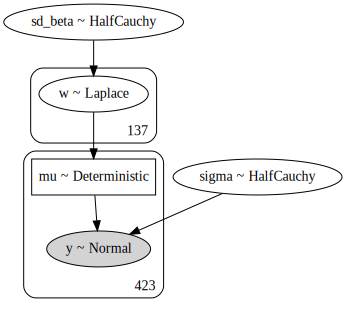

In [40]:
pm.model_to_graphviz(model=mp_lasso)

In [13]:
with mp_lasso:
    inference=pm.ADVI()
    approx_lasso_p = pm.fit(n=100000, method=inference)

Average Loss = 150.97: 100%|██████████| 100000/100000 [00:46<00:00, 2173.13it/s]
Finished [100%]: Average Loss = 150.96


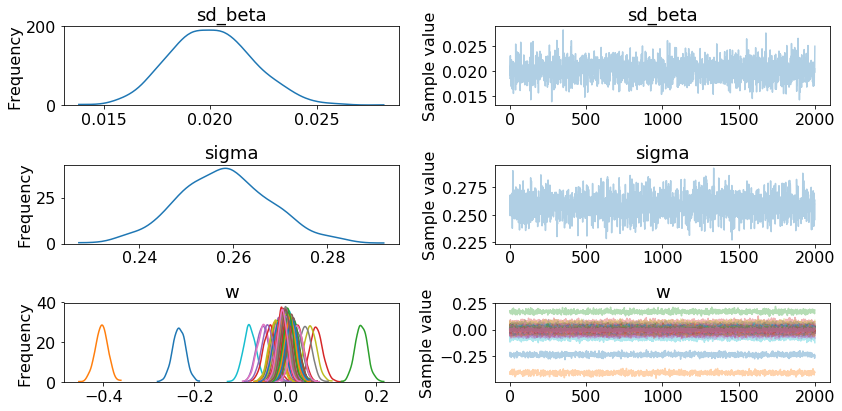

In [35]:
tp_lasso = approx_lasso_p.sample(draws=2000)
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(tp_lasso, varnames=vars_);

In [69]:
np.power(10, 0.22)

1.6595869074375607

100%|██████████| 2000/2000 [00:01<00:00, 1766.98it/s]


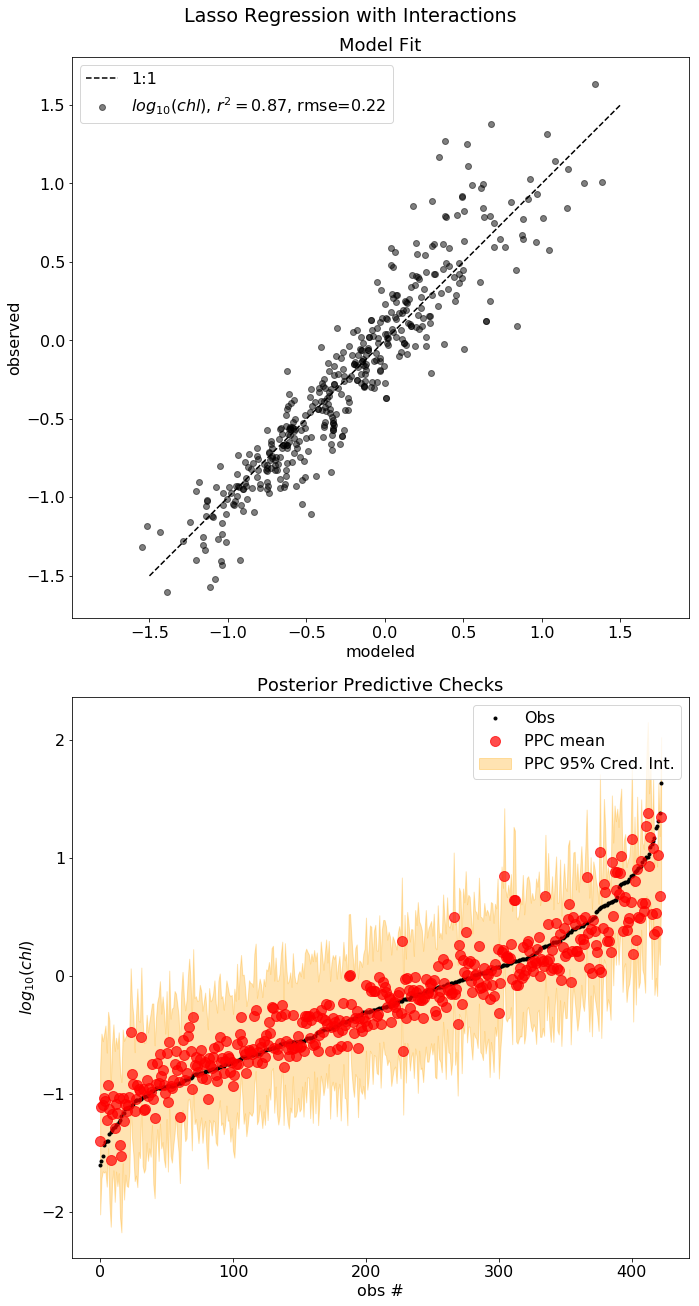

In [14]:
title = 'Lasso Regression with Interactions'
ax1lps = Plot_Model_Fits(tp_lasso, mp_lasso, title=title)

In [65]:
dp_lasso = pm.summary(tp_lasso, varnames=vars_)
lbls = dps.columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
dp_lasso.index = ['sd_beta', 'sigma'] + lbls_list
dp_lasso[(((dp_lasso['hpd_2.5']<0)&(dp_lasso['hpd_97.5']<0))|
          ((dp_lasso['hpd_2.5']>0) & (dp_lasso['hpd_97.5']>0)))]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sd_beta,0.020029,0.001942,0.000043,0.016539,0.023942
sigma,0.257961,0.009808,0.000219,0.237343,0.276359
w[bias],-0.233597,0.013922,0.000295,-0.263214,-0.208306
w [oisst],-0.078541,0.013929,0.000325,-0.104966,-0.050584
w [PC1],-0.403755,0.013638,0.000308,-0.431967,-0.378587
w [PC3],0.026140,0.013483,0.000300,0.000549,0.052671
w [sin_doy log10_etopo2],0.067302,0.014284,0.000311,0.040332,0.096253
w [sin_doy oisst],-0.050102,0.013591,0.000322,-0.077557,-0.024831
w [x PC1],-0.048619,0.013658,0.000295,-0.074850,-0.021348
w [x PC3],0.054640,0.013688,0.000322,0.027028,0.080411


In [19]:
mpcap_lasso = lasso_regression(Xpcap_s, y, ylabel='y')

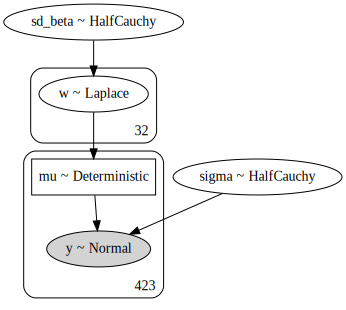

In [41]:
pm.model_to_graphviz(model=mpcap_lasso)

In [25]:
with mpcap_lasso:
    inference=pm.ADVI()
    approx_lasso_pca_p = pm.fit(n=100000, method=inference,progressbar=False)

Finished [100%]: Average Loss = 81.961


In [27]:
tpcap_lasso = approx_lasso_pca_p.sample(2000)

In [36]:
d_tpcap_lasso = tpcap_lasso.r

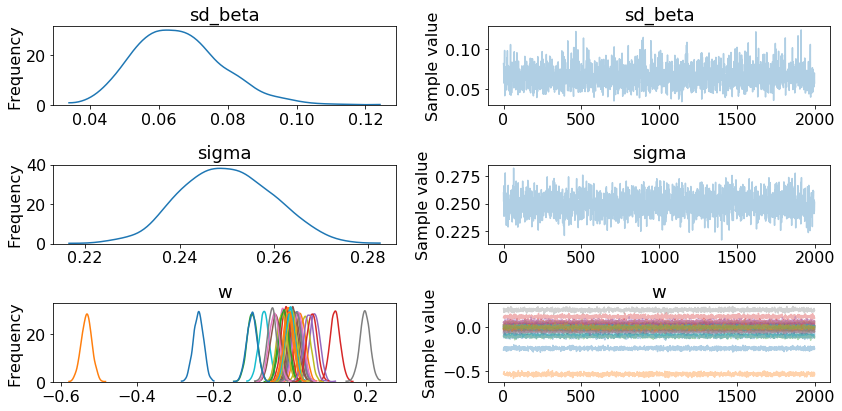

In [28]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(tpcap_lasso, varnames=vars_);

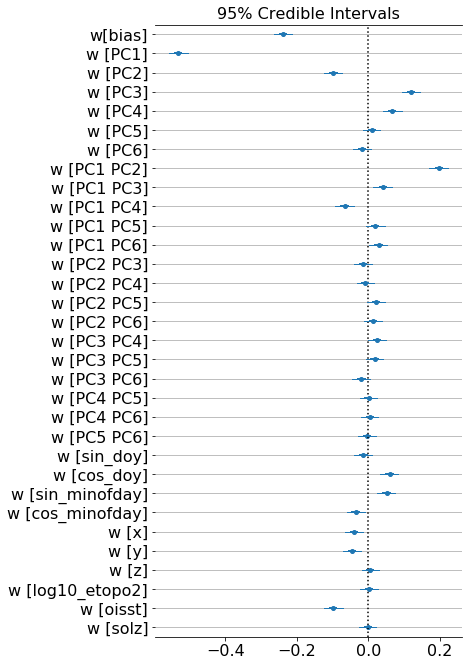

In [33]:
lbls = dpcapoly_s.columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
pm.forestplot(tpcap_lasso, varnames='w', ylabels=lbls_list);
f = pl.gcf()
f.set_figheight(10)
a = f.get_axes()[0]
a.grid(axis='y')


100%|██████████| 2000/2000 [00:01<00:00, 1662.91it/s]

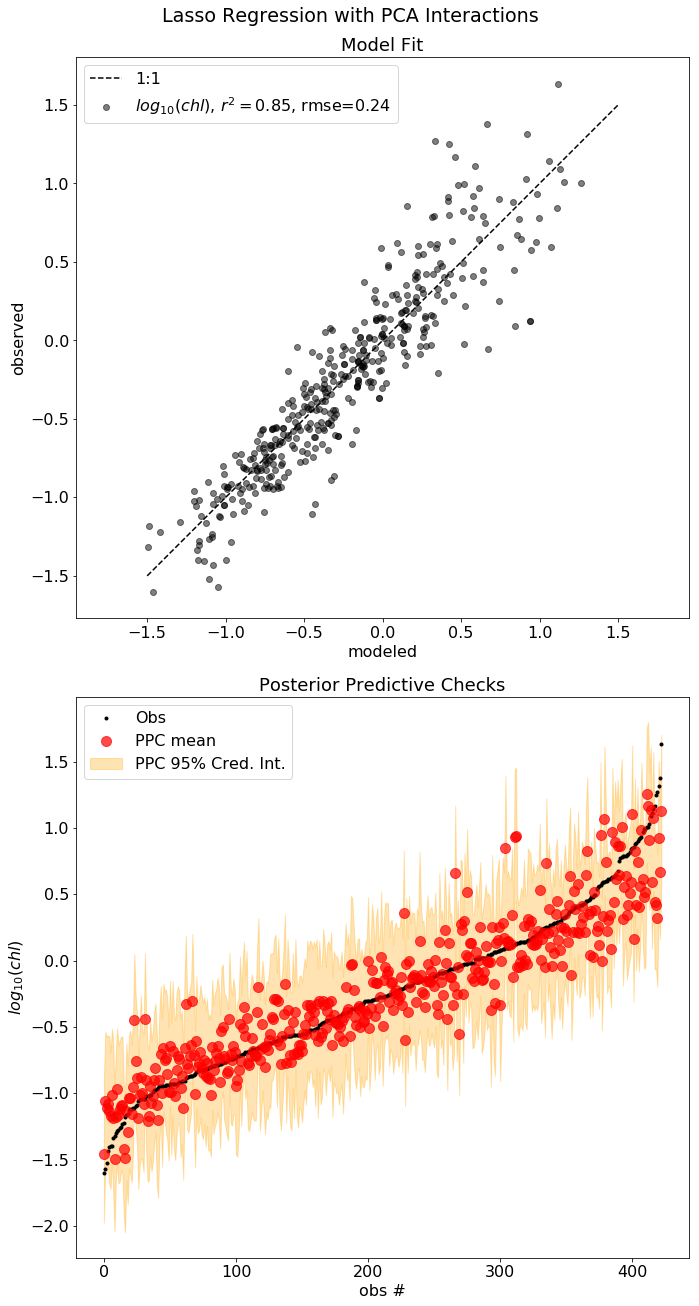

In [34]:
title = 'Lasso Regression with PCA Interactions'
ax1lps = Plot_Model_Fits(tpcap_lasso, mpcap_lasso, title=title)

In [68]:
dpcap_lasso = pm.summary(tpcap_lasso, varnames=vars_)
lbls = dpcapoly_s.columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
dpcap_lasso.index = ['sd_beta', 'sigma'] + lbls_list
dpcap_lasso[(((dpcap_lasso['hpd_2.5']<0)&(dpcap_lasso['hpd_97.5']<0))|
                    ((dpcap_lasso['hpd_2.5']>0) & (dpcap_lasso['hpd_97.5']>0))
                   )]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sd_beta,0.065861,0.012994,0.000284,0.042055,0.091530
sigma,0.249894,0.009548,0.000218,0.233459,0.269524
w[bias],-0.239103,0.013133,0.000290,-0.263986,-0.213842
w [PC1],-0.532667,0.013638,0.000301,-0.557090,-0.503189
w [PC2],-0.097995,0.013124,0.000292,-0.125468,-0.073805
w [PC3],0.119855,0.012989,0.000268,0.093828,0.145157
w [PC4],0.066158,0.013283,0.000296,0.041843,0.093206
w [PC1 PC2],0.197818,0.013182,0.000317,0.170136,0.222129
w [PC1 PC3],0.040437,0.013730,0.000303,0.012179,0.065599
w [PC1 PC4],-0.067048,0.013407,0.000268,-0.092716,-0.039384
